# 03 – Evaluation for Imbalanced Data

## Objective

Design **correct, business-aligned evaluation strategies** for fraud and anomaly detection problems where:

* Positive events are **rare**
* False negatives are **expensive**
* Accuracy and naive ROC-AUC are misleading

This notebook treats evaluation as a **decision optimization problem**, not a reporting exercise.



## Why Standard Metrics Fail

In imbalanced settings:

* 99% accuracy can mean *zero fraud detected*
* ROC-AUC can look strong while precision is unusable
* Default thresholds (0.5) are almost always wrong

Correct evaluation must answer:

> *Which operating point minimizes business loss?*



## Imports and Setup

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)

In [19]:
DATA_PATH = "D:/GitHub/Data-Science-Techniques/datasets/Anomaly-fraud-detection"
df = pd.read_csv(DATA_PATH + '/' + 'data.csv')

df.head()

,log_amount,tx_count_1h,tx_count_24h,amount_sum_1h,amount_vs_user_mean,is_fraud
0,2.894296,4,8,147.751332,1.741961,0
1,2.490703,1,3,258.166718,0.042524,0
2,3.734484,0,4,117.667634,1.491628,0
3,2.979201,1,3,55.274887,0.968212,0
4,0.583843,2,10,95.122333,0.627956,0


In [21]:
DATA_PATH = "D:/GitHub/Data-Science-Techniques/datasets/Anomaly-fraud-detection"
results = pd.read_csv(DATA_PATH + '/' + 'score_df.csv')

results.head()

,fraud_probability,is_fraud
0,0.315452,0
1,0.209577,0
2,0.262915,0
3,0.256334,0
4,0.273000,0


## Assumed Inputs

From previous notebook (`02_supervised_fraud_classification.ipynb`):

* `y_true`: ground truth labels (0 = normal, 1 = fraud)
* `y_proba`: predicted fraud probabilities

In [23]:
results.columns = ["y_proba", "y_true"]

In [25]:
y_true = results["y_true"].values
y_proba = results["y_proba"].values

## Precision–Recall Curve (Primary Diagnostic)

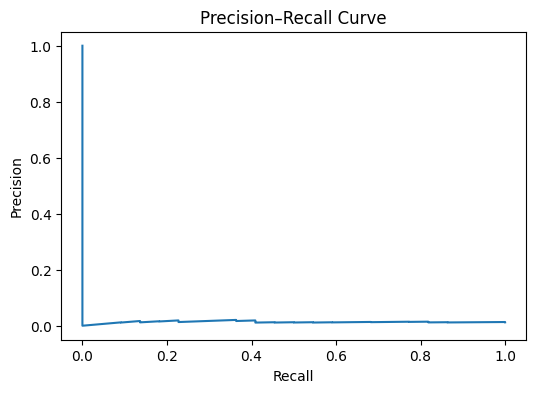

In [28]:
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

### Interpretation

* **Recall** = frauds caught
* **Precision** = alert quality

The curve visualizes the *trade-off frontier*.


## PR-AUC vs ROC-AUC

In [31]:
pr_auc = average_precision_score(y_true, y_proba)
roc_auc = roc_auc_score(y_true, y_proba)

print("PR-AUC:", pr_auc)
print("ROC-AUC:", roc_auc)

PR-AUC: 0.014207781722729074
ROC-AUC: 0.5304734635443297


### Key Principle

* **PR-AUC** reflects real-world usefulness
* **ROC-AUC** hides class imbalance

> In fraud systems, PR-AUC is the primary score.

## Threshold Analysis

In [35]:
threshold_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

threshold_df.head()

,threshold,precision,recall
0,0.026671,0.012222,1.0
1,0.026841,0.012229,1.0
2,0.027879,0.012236,1.0
3,0.033152,0.012243,1.0
4,0.034564,0.012249,1.0


This table allows **explicit operating point selection**.

## Cost-Sensitive Evaluation

Assume business costs:

* False Negative (missed fraud): $500
* False Positive (false alert): $5

In [42]:
FN_COST = 500
FP_COST = 5

def compute_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * FN_COST + fp * FP_COST

In [44]:
## Cost Curve Across Thresholds

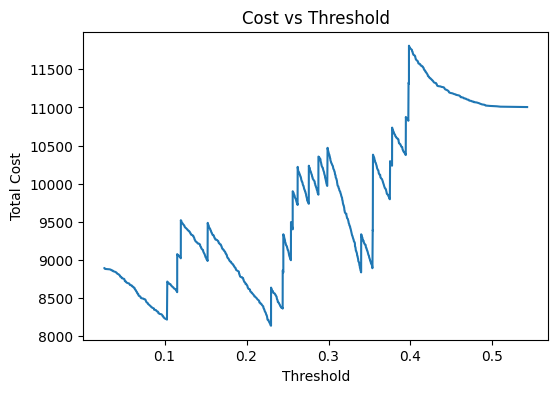

In [46]:
costs = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    costs.append(compute_cost(y_true, y_pred))

plt.figure(figsize=(6, 4))
plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Cost vs Threshold")
plt.show()

### Optimal Threshold

In [49]:
optimal_threshold = thresholds[np.argmin(costs)]
optimal_threshold

np.float64(0.2298992457534674)

This threshold is **business-optimal**, not statistically arbitrary.

## Confusion Matrix at Optimal Threshold

In [53]:
y_opt = (y_proba >= optimal_threshold).astype(int)
confusion_matrix(y_true, y_opt)

array([[ 551, 1227],
       [   4,   18]])

Interpret results in terms of:
- 
* Investigations triggered
* Frauds prevented
* Operational load



## Key Anti-Patterns to Avoid

- ❌ Optimizing accuracy
- ❌ Reporting ROC-AUC alone
- ❌ Using default 0.5 threshold
- ❌ Ignoring alert capacity
- ❌ Treating metrics as static



## Production Evaluation Checklist

- ✔ PR-AUC tracked
- ✔ Threshold tied to cost
- ✔ Confusion matrix reviewed
- ✔ Alert volume understood
- ✔ Metrics monitored over time



## How This Fits the Fraud Pipeline

| Stage       | Contribution           |
| ----------- | ---------------------- |
| Feature Eng | No leakage into labels |
| Modeling    | Probability outputs    |
| Evaluation  | Cost-aware decisions   |
| Deployment  | Threshold locked       |
| Monitoring  | Metric drift detection |



## Final Principle

> **In imbalanced problems, models produce scores — businesses make decisions.**

Evaluation is the bridge between the two.